# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [1]:
!pip install unrar
!pip install rarfile

In [64]:

import tensorflow as tf
import csv
import numpy as np
from PIL import Image

import pandas as pd
from zipfile import ZipFile
from unrar import rarfile
import cv2
import random

In [4]:
from tensorflow.keras import Model
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.layers import Conv2D, Reshape
from tensorflow.keras.utils import Sequence
from tensorflow.keras.backend import epsilon

### Change directory

### Load the training data from train.csv file

In [5]:
df = pd.read_csv('train_labels.csv')

### Print the shape of the train dataset

In [6]:
df.shape

(173, 8)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 8 columns):
filename    173 non-null object
width       173 non-null int64
height      173 non-null int64
class       173 non-null object
xmin        173 non-null int64
ymin        173 non-null int64
xmax        173 non-null int64
ymax        173 non-null int64
dtypes: int64(6), object(2)
memory usage: 10.9+ KB


In [8]:
df['class'].value_counts()

raccoon    173
Name: class, dtype: int64

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [9]:
IMAGE_SIZE = 128

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [16]:
with open('train_labels.csv', 'r') as csvfile:
    path = []
    coords = np.zeros((sum(1 for line in csvfile)-1, 4)) # Subtracting -1, to ignore the header line from the count
    reader = csv.reader(csvfile, delimiter=',')
    csvfile.seek(0)
    next(reader) # Calling next to read and ignore the header line

    for col, row in enumerate(reader):
        #print(row)
        for i, r in enumerate(row[0:8]):
            #print(r, i)
            row[i] = r
            
        img_path, width, height, _, x0, y0, x1, y1  = row
        coords[col, 0] = int(x0) * IMAGE_SIZE / int(width)
        coords[col, 1] = int(y0) * IMAGE_SIZE / int(height)
        coords[col, 2] = (int(x1) - int(x0)) * IMAGE_SIZE / int(width)
        coords[col, 3] = (int(y1) - int(y0)) * IMAGE_SIZE / int(height)
        path.append("./images/"+img_path)

In [17]:
coords.shape

(173, 4)

In [18]:
len(path)

173

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [19]:
images_zip_path = 'images_racoon.rar'
with rarfile.RarFile(images_zip_path) as rf:
    rf.extractall()

In [20]:
batch_images = np.zeros((len(path), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)

In [22]:
for i, fil in enumerate(path):
    #print(i, fil)
    img = Image.open(fil)
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
    img = img.convert('RGB')
    batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))

In [23]:
batch_images.shape

(173, 128, 128, 3)

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [36]:
model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False)

In [37]:
for layer in model.layers:
    layer.trainable = False

In [38]:
x = model.layers[-1].output
x = Conv2D(4, kernel_size=4, name='coords')(x)
x = Reshape((4,))(x)

model = Model(inputs = model.input, outputs = x)

In [39]:
#model.summary()

### Define a custom loss function IoU which calculates Intersection Over Union

In [40]:
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_function(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [41]:
model.compile(optimizer='Adam', loss='mse', metrics=[IoU])

In [42]:
epochs=30
batch_size=32

In [43]:
coords.shape

(173, 4)

In [44]:
batch_images.shape

(173, 128, 128, 3)

In [45]:
model.fit(batch_images, coords, epochs=30, batch_size=32, verbose=1)

Epoch 1/30
6/6 [==============================] - 1s 183ms/step - loss: 2750.3188 - IoU: 0.1010
Epoch 2/30
6/6 [==============================] - 1s 178ms/step - loss: 676.0120 - IoU: 0.4397
Epoch 3/30
6/6 [==============================] - 1s 179ms/step - loss: 701.2939 - IoU: 0.5307
Epoch 4/30
6/6 [==============================] - 1s 185ms/step - loss: 543.8980 - IoU: 0.5418
Epoch 5/30
6/6 [==============================] - 1s 207ms/step - loss: 318.2507 - IoU: 0.5822
Epoch 6/30
6/6 [==============================] - 1s 196ms/step - loss: 249.9364 - IoU: 0.5794
Epoch 7/30
6/6 [==============================] - 1s 203ms/step - loss: 206.3213 - IoU: 0.6478
Epoch 8/30
6/6 [==============================] - 1s 222ms/step - loss: 167.7845 - IoU: 0.6956
Epoch 9/30
6/6 [==============================] - 1s 179ms/step - loss: 133.3833 - IoU: 0.7248
Epoch 10/30
6/6 [==============================] - 1s 185ms/step - loss: 116.0811 - IoU: 0.7524
Epoch 11/30
6/6 [==============================]

### Pick a test image from the given data

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

### Predict the coordinates of the bounding box for the given test image

In [71]:
def predict_bbox(img_path):
    test_unscaled_image = cv2.imread(img_path)
    
    unscaled_height, unscaled_width, _ = test_unscaled_image.shape
    
    test_image = cv2.resize(test_unscaled_image,(IMAGE_SIZE, IMAGE_SIZE))
    test_scaled = preprocess_input(np.array(test_image, dtype=np.float32))
    
    region = model.predict(x=np.array([test_scaled]))[0]
    return region, test_unscaled_image, unscaled_height, unscaled_width

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

In [72]:
def plot_boxes(region, test_unscaled_image, unscaled_height, unscaled_width ):
    x0 = int(region[0] * unscaled_width / IMAGE_SIZE) # Scale the BBox
    y0 = int(region[1] * unscaled_height / IMAGE_SIZE)

    x1 = int((region[2]) * unscaled_width / IMAGE_SIZE)
    y1 = int((region[3]) * unscaled_height / IMAGE_SIZE)


    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    from PIL import Image
    import numpy as np


    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    #ax.imshow(unscaled)
    ax.imshow(test_unscaled_image)

    # Create a Rectangle patch
    rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    plt.show()

./images/raccoon-113.jpg


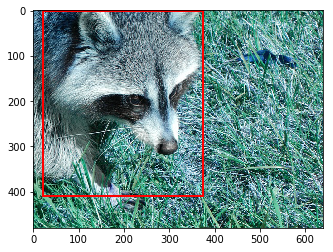

./images/raccoon-53.jpg


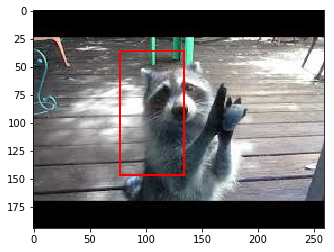

./images/raccoon-131.jpg


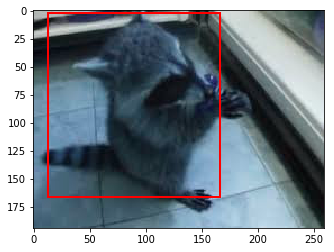

./images/raccoon-153.jpg


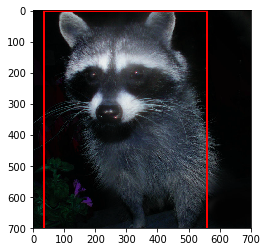

./images/raccoon-9.jpg


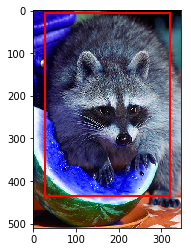

In [73]:
for x in range(0, 5):
    rand_number = random.randint(0,173)
    test_file = './images/raccoon-{}.jpg'.format(rand_number)
    print(test_file)
    region, test_unscaled_image, unscaled_height, unscaled_width = predict_bbox(test_file)
    plot_boxes(region, test_unscaled_image, unscaled_height, unscaled_width)